In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing google drive to access dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import andrews_curves
import seaborn as sns
import xgboost as xgb
import numpy as np
import os
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

path_train = '/content/drive/MyDrive/Data/train_data.csv'
train_df = pd.read_csv(path_train)

path_val = '/content/drive/MyDrive/Data/val_data.csv'
val_df = pd.read_csv(path_val)

path_test = '/content/drive/MyDrive/Data/test_data.csv'
test_df = pd.read_csv(path_test)

Imports and getting the dataset ready to be used by the models.

In [ ]:
X = train_df.columns.difference(['diabetes'])
y = ['diabetes']

X_train = train_df[X]
print('X_train, our input variables:')
print(X_train.head())
print()

y_train = train_df[y]
print('y_train, our output variable:')
print(y_train.head())

X_train, our input variables:
   HbA1c_level   age  blood_glucose_level    bmi  gender  heart_disease  \
0          4.0  36.0                  145  17.06     1.0              0   
1          6.1  58.0                  159  37.83     0.0              0   
2          5.0  43.0                  160  39.20     0.0              0   
3          5.7  67.0                  159  28.39     1.0              0   
4          6.0   5.0                   80  27.32     0.0              0   

   hypertension  smoking_history_current  smoking_history_ever  \
0             0                        0                     0   
1             0                        0                     0   
2             0                        0                     0   
3             1                        0                     0   
4             0                        0                     0   

   smoking_history_former  smoking_history_never  smoking_history_not current  
0                       0                 

Assigning data to X_train and y_train.

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

In [ ]:
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train_imputed, y_train)

In [ ]:
X_val = val_df[X]
y_val = val_df[y]

In [ ]:
X_test = test_df[X]
y_test = test_df[y]

In [ ]:
scaler = StandardScaler()
X_adasyn_scaled = scaler.fit_transform(X_adasyn)
X_test_scaled = scaler.transform(X_val)

The code uses a StandardScaler to standardize the features of two datasets, X_adasyn and X_val. The fit_transform method scales the training data (X_adasyn), while the transform method scales the validation data (X_val) using the parameters learned from the training data.

In [ ]:
xgb_train = xgb.DMatrix(X_adasyn, label=y_adasyn)

params = {
    'max_depth': 4,
    'min_child_weight': 3,
    'gamma': 0.1,
    'eta': 0.005,  # kind of like LR for XGBoost
    'silent': 1,  # quiet logging mode
    'objective': 'binary:logistic'
    }

num_round = 5

bst = xgb.train(params, xgb_train, num_round)


The code sets up and trains an XGBoost classifier. It converts the training data (X_adasyn and y_adasyn) into a specific data structure (xgb.DMatrix) for XGBoost, defines hyperparameters (max_depth, eta, silent, objective), and trains the model for a specified number of rounds (num_round).

In [ ]:
y_train_pred_probs = bst.predict(xgb_train)
y_train_pred = [1 if prob > 0.5 else 0 for prob in y_train_pred_probs]

# Calculate and print accuracy on the training set
accuracy_train = accuracy_score(y_adasyn, y_train_pred)
print(f"Training Accuracy with ADASYN: {accuracy_train}")

Training Accuracy with ADASYN: 0.8688395145713627


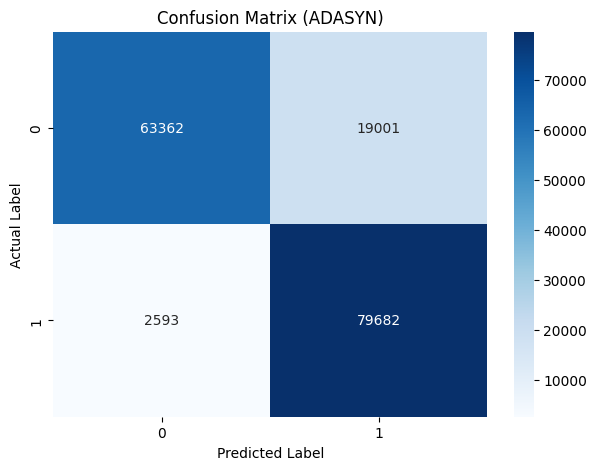

In [ ]:
cm = confusion_matrix(y_adasyn, y_train_pred)
cm_df = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix (ADASYN)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

The code computes a confusion matrix using the predicted values (y_pred_val) and actual labels (y_val). It then visualizes the confusion matrix using a heatmap, providing an overview of the model's performance in terms of true positives, true negatives, false positives, and false negatives.

Accuracy for predicting the diabetes label on the training set: (79682/82275) * 100 = 97%

In [ ]:
xgb_val = xgb.DMatrix(X_val)

y_pred_probs = bst.predict(xgb_val)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.783


Computes the accuracy of the overall model.

In [ ]:
xgb_test = xgb.DMatrix(X_test)

y_pred_probs = bst.predict(xgb_test)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

accuracy = accuracy_score(y_test, y_pred)
print(f"Test set Accuracy: {accuracy}")

Test set Accuracy: 0.7788


In [ ]:
cm = confusion_matrix(y_val, y_pred)

In [ ]:
cm_df = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])

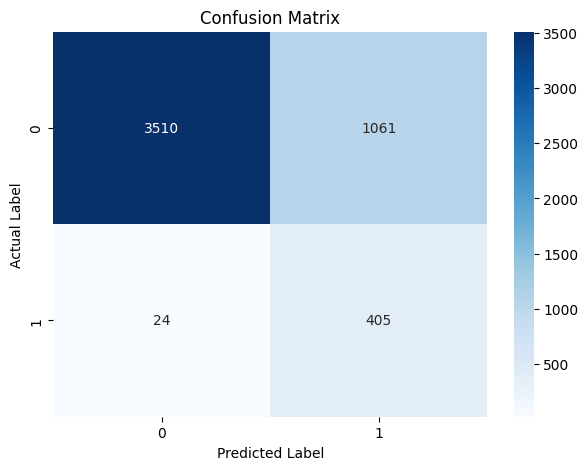

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Accuracy for predicting the diabetes label on the validation set: (405/429) * 100 = 94.4%

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm_df = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])

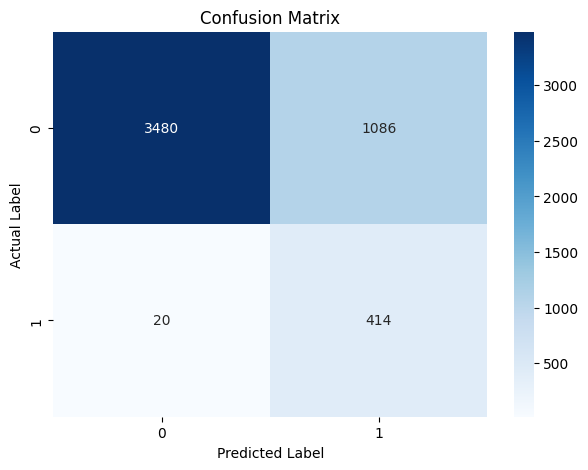

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

The accuracy for predicting the diabetes label on test set is: (414/434) * 100 = 95.4%